In [2]:
import cv2, os, io
import tarfile, requests
import numpy as np
import matplotlib.pyplot as plt
from CompressedImage import CompressedImage


In [11]:
url = "https://image-net.org/data/ILSVRC/2017/ILSVRC2017_DET_test_new.tar.gz"
filename = "ILSVRC2017_DET_test_new.tar.gz"

if not os.path.exists(filename):
    print("Downloading...")
    r = requests.get(url, stream=True)

    with open(filename, "wb") as f:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            if chunk:
                f.write(chunk)
    print("Finished Downloading")
else:
    print("Already Downloaded")

Already Downloaded


In [12]:
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()

/var/folders/h8/x7_s6v7j7ysb1s710mg3pslc0000gn/T/ipykernel_50820/3173168160.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [3]:
#Converts to np.float32 to avoid underflow 
def relativeFrobeniusError(a: np.ndarray, b: np.ndarray) -> float:
    aF = a.astype(np.float32)
    bF = b.astype(np.float32)
    return float(np.linalg.norm(aF - bF) / np.linalg.norm(aF))

In [4]:
def benchmarkOnImageSVD(image: np.ndarray, benchmarkPoints:list[float]) -> list[float]:
    compressedImage:CompressedImage = CompressedImage.loadImage(image)
    compressionRatios:list[float] = [-1]*len(benchmarkPoints)
    compressionRatioIndex:int = 0
    approximation:np.ndarray = np.zeros(image.shape)
    for k in range(compressedImage.getMaxK()):
        approximation += compressedImage.kthLayer(k)
        relativeError = relativeFrobeniusError(image, approximation)
        while compressionRatioIndex < len(benchmarkPoints):
            if relativeError <= benchmarkPoints[compressionRatioIndex]:
                compressionRatios[compressionRatioIndex] = 1 - compressedImage.getNumBytes(k)/image.nbytes
                compressionRatioIndex += 1
            else:
                break
        if compressionRatioIndex == len(benchmarkPoints):
            break
    return compressionRatios


In [27]:
def benchmarkOnImageBuiltin(image: np.ndarray, benchmarkPoints:list[float], imageFormat:str) -> list[float]:
    compressionRatios:list[float] = [-1]*len(benchmarkPoints)
    compressionRatioIndex:int = 0

    protocol:int = 0
    if imageFormat == ".jpg":
        protocol = cv2.IMWRITE_JPEG_QUALITY
    elif imageFormat == ".webp":
        protocol = cv2.IMWRITE_WEBP_QUALITY
    elif imageFormat == ".jp2":
        protocol = cv2.IMWRITE_JPEG2000_COMPRESSION_X1000

    for quality in range(100):
        _, enc = cv2.imencode(imageFormat, image, [protocol, quality])
        dec = cv2.imdecode(enc, cv2.COLOR_BGR2RGB)
        relativeError = relativeFrobeniusError(image, dec)        
        while compressionRatioIndex < len(benchmarkPoints):
            if relativeError <= benchmarkPoints[compressionRatioIndex]:
                compressionRatios[compressionRatioIndex] = 1 - enc.nbytes/image.nbytes
                compressionRatioIndex += 1
            else:
                break
        if compressionRatioIndex == len(benchmarkPoints):
            break
    return compressionRatios

In [29]:
originalImage = cv2.imread(os.path.join("images", "colordog.png"))
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
benchmarkOnImageBuiltin(originalImage, np.arange(0.95, 0, -0.05).tolist(), ".jp2")

[0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9989985392930179,
 0.9960009738046548,
 0.9729973707274321]

In [49]:
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
from typing import Callable

PARAMS = np.arange(0.95, 0.05, -0.01).tolist()

def processSVD(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return benchmarkOnImageSVD(img, PARAMS) 

def processJPEG(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return benchmarkOnImageBuiltin(img, PARAMS, ".jpg") 

def processWEBP(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return benchmarkOnImageBuiltin(img, PARAMS, ".webp") 

def processJPEG2000(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return benchmarkOnImageBuiltin(img, PARAMS, ".jp2") 


def runBenchmarkFolder(root: str,
                         processFunction: Callable[[str], list[float]],
                         maxImages: int = -1,
                         numThreads: int = -1) -> list[float]:
    exts = (".png", ".jpg", ".jpeg")
    files = [os.path.join(root, f) for f in os.listdir(root)
             if f.lower().endswith(exts)]
    files.sort()

    if maxImages != -1:
        files = files[:maxImages]

    if numThreads == -1:
        numThreads = cpu_count()

    with ThreadPoolExecutor(max_workers=numThreads) as pool:
        results = list(pool.map(processFunction, files))

    results = [r for r in results if r is not None]#delete garbage results

    arr = np.array(results, dtype=float)
    return arr.mean(axis=0).tolist()


In [50]:
resultsWEBP = runBenchmarkFolder("ILSVRC/Data/DET/test", processWEBP, maxImages=1000)
resultsJPEG = runBenchmarkFolder("ILSVRC/Data/DET/test", processJPEG, maxImages=1000)
resultsJPEG2000 = runBenchmarkFolder("ILSVRC/Data/DET/test", processJPEG2000, maxImages=1000)


In [52]:
resultsSVD = runBenchmarkFolder("ILSVRC/Data/DET/test", processSVD, maxImages=1000)


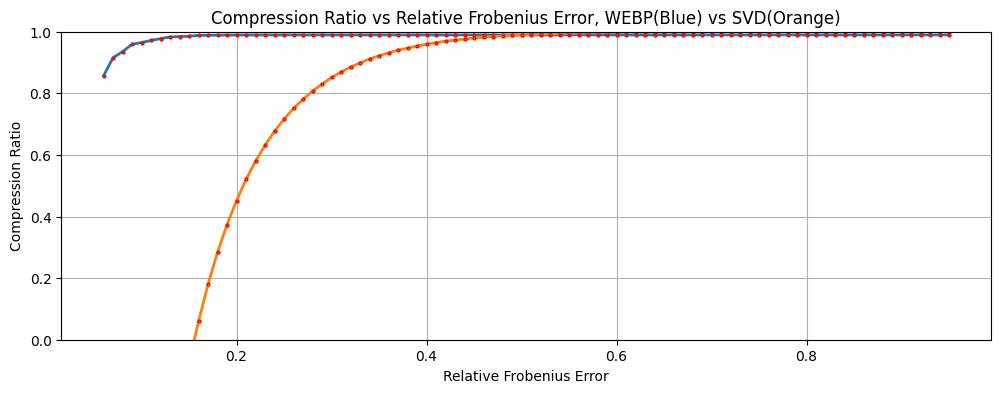

In [65]:
plt.figure(figsize=(12, 4))
plt.plot(PARAMS, resultsWEBP, label = "WEBP",  marker='o', markersize=2, markeredgecolor='red', linewidth=2)
plt.plot(PARAMS, resultsSVD, label = "SVD", marker='o', markersize=2, markeredgecolor='red', linewidth=2)

plt.ylim(0, 1)
plt.xlabel("Relative Frobenius Error")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Relative Frobenius Error, WEBP(Blue) vs SVD(Orange)")
plt.grid(True)

plt.show()

In [84]:
print(resultsJPEG[75]/resultsSVD[75])
print(resultsJPEG[45]/resultsSVD[45])

#0.4517568158352367

2.186666985460437
1.0012916694883696


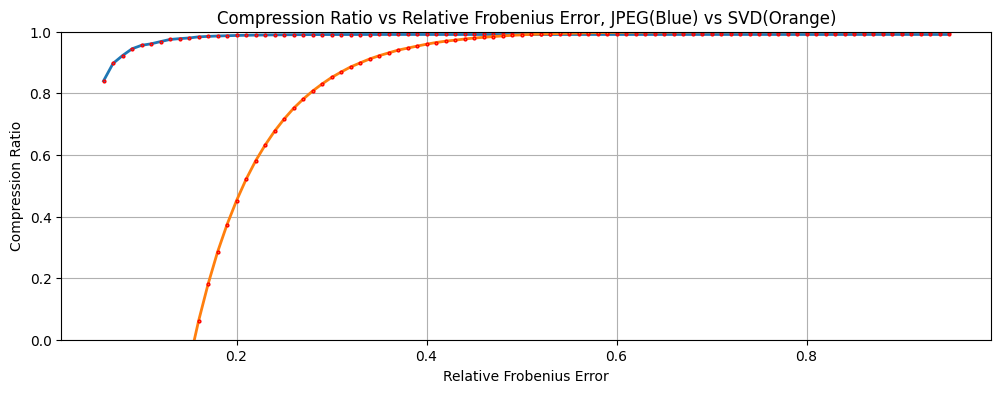

In [64]:
plt.figure(figsize=(12, 4))
plt.plot(PARAMS, resultsJPEG, label = "JPEG", marker='o', markersize=2, markeredgecolor='red', linewidth=2)
plt.plot(PARAMS, resultsSVD, label = "SVD", marker='o', markersize=2, markeredgecolor='red', linewidth=2)

plt.ylim(0, 1)
plt.xlabel("Relative Frobenius Error")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Relative Frobenius Error, JPEG(Blue) vs SVD(Orange)")
plt.grid(True)

plt.show()

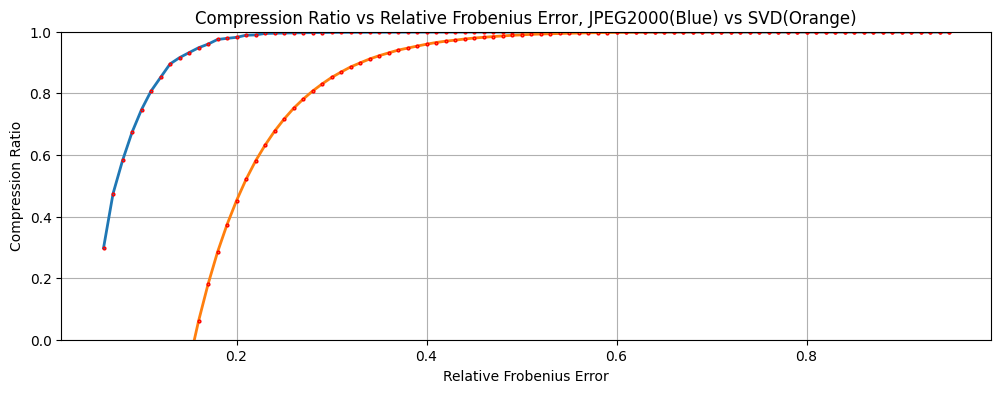

In [63]:
plt.figure(figsize=(12, 4))
plt.plot(PARAMS, resultsJPEG2000, label = "JPEG2000", marker='o', markersize=2, markeredgecolor='red', linewidth=2)
plt.plot(PARAMS, resultsSVD, label = "SVD", marker='o', markersize=2, markeredgecolor='red', linewidth=2)

plt.ylim(0, 1)
plt.xlabel("Relative Frobenius Error")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Relative Frobenius Error, JPEG2000(Blue) vs SVD(Orange)")
plt.grid(True)

plt.show()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9999199279279279, 0.9998798558558558, 0.9998798558558558, 0.9998798558558558, 0.9998798558558558, 0.9998798558558558, 0.9998798558558558, 0.9997151129492481, 0.999675112949248, 0.999635040877176, 0.999594968805104, 0.9995148246609599, 0.9993946805168157, 0.9992454844684123, 0.9990807415618046, 0.9989614297876026, 0.9988813577155307, 0.9985730301953596, 0.9982872027278308, 0.9980075051766591, 0.9977675725538305, 0.9974594852040897, 0.9969606085573878, 0.9964776690965584, 0.9956829476599905, 0.995077913865607, 0.9942338395130464, 0.9934169173882041, 0.992493113812113, 0.9914231729304307, 0.9897615277275945, 0.9882896409387878, 0.986295544791192, 0.9841987971710718, 0.9818512240101409, 0.9794659587678117, 0.9763317136635336, 0.9726461977157486, 0.9692679639344556, 0.9649905519786901, 0.9594719221072914, 0.9533189201005504, 0.9467360688993544, 0.9402515561531778, 0.9312045561556498, 0.9220511337307

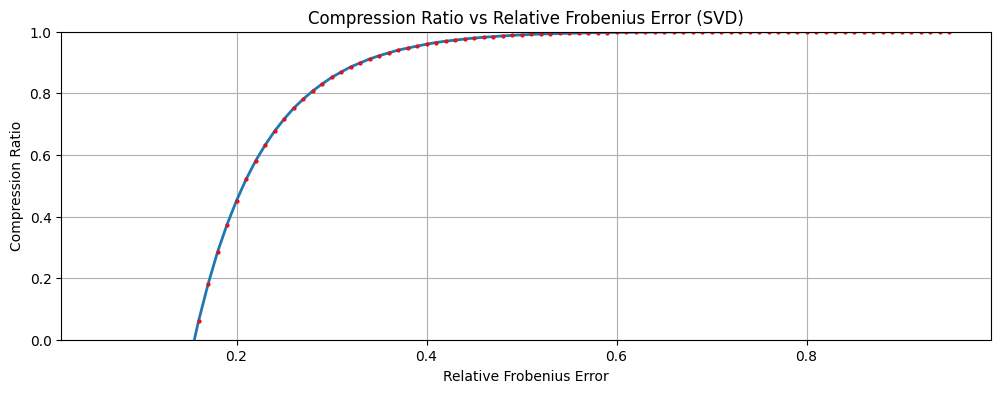

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(PARAMS, resultsSVD, marker='o', markersize=2, markeredgecolor='red', linewidth=2)
plt.ylim(0, 1)
print(resultsSVD)
plt.xlabel("Relative Frobenius Error")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Relative Frobenius Error (SVD)")
plt.grid(True)

plt.show()